In [5]:
import time, sys, os
import h5py
import numpy as np
import scipy
import matplotlib.pyplot as plt
import fsps
import sedpy
import prospect
from prospect.utils.obsutils import fix_obs
from glob import glob
from astropy.wcs import WCS
from astropy.io import fits
from prospect.models.templates import TemplateLibrary
from prospect.models import priors
from prospect.models import SpecModel
from multiprocessing import Pool
from prospect.plotting.sfh import parametric_sfr, params_to_sfh,parametric_pset,compute_mass_formed
from prospect.io import read_results as reader
from prospect.plotting.corner import quantile

In [6]:
gal='MCG05'
files={'MCG05':'./quickstart_emcee_MCG05_1.h5',
    'MCG06':'./quickstart_emcee_MCG06_2.h5',
    'NGC3016':'./quickstart_emcee_mcmc16.h5',
    'NGC6365A':'./quickstart_emcee_NGC6365A.h5',
    'NGC3705':'./quickstart_emcee_NGC3705.h5',
    'NVSSJ09': './quickstart_emcee_NVSSJ09_2.h5',
    'UGC9379':'./quickstart_emcee_UGC9379.h5'}
results_type = "emcee"
def create_walker_mask(cropped_chain,parameter_ind,min_val,max_val,checkind=-1):
    mask=np.zeros(128,dtype=bool)
    mask.fill(False)
    for i in range(len(mask)):
        val=cropped_chain[i,checkind,parameter_ind]
        if min_val<val and val<max_val:
            mask[i]=True
    return mask
hfile=files[gal]
result, obs, _ = reader.results_from(hfile.format(results_type), dangerous=False)

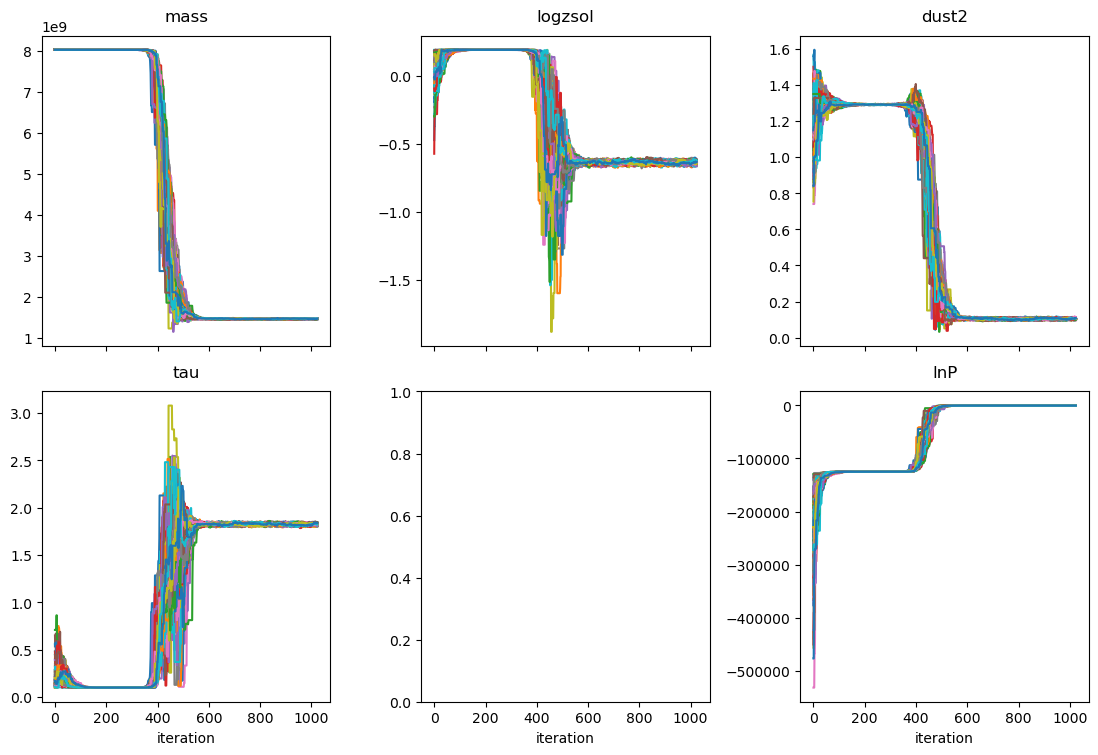

In [21]:
#Initial Diagnoses
tfig = reader.traceplot(result)
#cfig = reader.subcorner(result,start=800)

In [27]:
mask=create_walker_mask(result['chain'],1,-0.75,-0.45,checkind=-10)
#mask=np.zeros(128,dtype=bool).fill(True)
imax = np.argmax(result['lnprobability'][mask,start:])
start=800
cropped_chain=result["chain"][mask,start:,::]
csz = cropped_chain.shape
print(csz)
i, j = np.unravel_index(imax, result['lnprobability'][mask,start:].shape)
print(i,j)
theta_max = cropped_chain[i, j, :].copy()
flatchain = cropped_chain.reshape(csz[0] * csz[1], csz[2])
# 16th, 50th, and 84th percentiles of the posterior
weights = result.get("weights", None)
print(flatchain.T.shape)
post_pcts = quantile(flatchain.T, q=[0.16, 0.50, 0.84], weights=weights)
print(post_pcts)

(121, 224, 4)
14 176
(4, 27104)
[[ 1.45457763e+09  1.45958541e+09  1.46464075e+09]
 [-6.46988306e-01 -6.37468564e-01 -6.27549957e-01]
 [ 1.00878217e-01  1.04422302e-01  1.07939333e-01]
 [ 1.81687297e+00  1.82644528e+00  1.83592548e+00]]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 69, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]


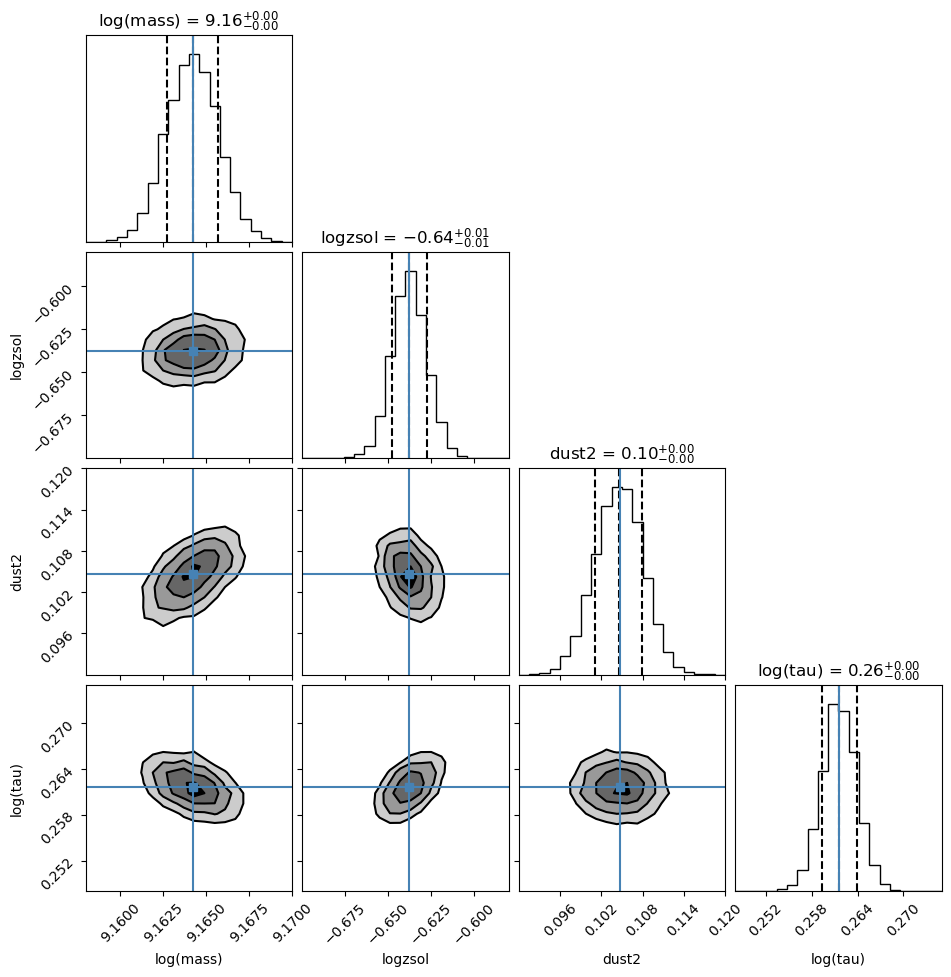

In [29]:
walker_inds=[num for num,val in enumerate(mask) if val]
print(walker_inds)
cornerfig = reader.subcorner(result, start=600, thin=5, truths=theta_max, 
                               fig=plt.subplots(4,4,figsize=(10,10))[0],chains=walker_inds,range=[(9.158,9.17),(-0.7,-0.58),(0.09,0.12),(0.248,0.275)])